In [1]:
import numpy as np
import imageio
import os
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import time
from torchmetrics.functional import dice

/home/zhesu157/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_image():
    # Loads the MNIST dataset from png images
 
    NUM_TRAIN = 85
    NUM_TEST = 60 
    # create list of image objects
    test_images = []
    test_labels = []    
    
    for idx in range(1, NUM_TEST+1):
        prefix_test = "WARWICK/Test/image_0" if idx < 10 else "WARWICK/Test/image_"
        prefix_label = "WARWICK/Test/label_0" if idx < 10 else "WARWICK/Test/label_"
        image_path_test = prefix_test + str(idx) + ".png"
        image_path_label = prefix_label + str(idx) + ".png"
        image = imageio.imread(image_path_test)
        test_images.append(image)
        label = imageio.imread(image_path_label)
        test_labels.append(label)  
            
    # create list of image objects
    train_images = []
    train_labels = []    

    for idx in range(1, NUM_TRAIN+1):
        prefix_test = "WARWICK/Train/image_0" if idx < 10 else "WARWICK/Train/image_"
        prefix_label = "WARWICK/Train/label_0" if idx < 10 else "WARWICK/Train/label_"
        image_path_test = prefix_test + str(idx) + ".png"
        image_path_label = prefix_label + str(idx) + ".png"
        image = imageio.imread(image_path_test)
        train_images.append(image)
        label = imageio.imread(image_path_label)
        train_labels.append(label)                  
    
    return train_images, train_labels, test_images, test_labels

In [3]:
# load image data
X_train, Y_train, X_test, Y_test = load_image()


/tmp/ipykernel_1581/2035333062.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path_test)
/tmp/ipykernel_1581/2035333062.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(image_path_label)
/tmp/ipykernel_1581/2035333062.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path_test)
/tmp/ipykern

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# move data to the device
X_train = torch.from_numpy(np.array(X_train)).float().to(device)
Y_train = torch.from_numpy(np.array(Y_train)).float().to(device)
X_test = torch.from_numpy(np.array(X_test)).float().to(device)
Y_test = torch.from_numpy(np.array(Y_test)).float().to(device)

print(X_train.shape)

torch.Size([85, 128, 128, 3])


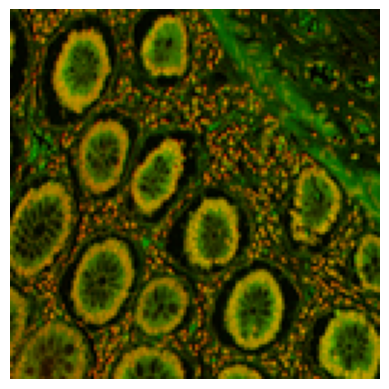

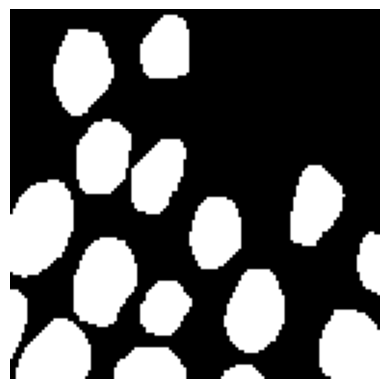

In [5]:
#display an sample image and its label

plt.imshow(X_train[19].cpu().squeeze().numpy()/255, cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(Y_train[19].cpu().squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [6]:
# Reshape the data to 4D tensor - (sample_number, num_channels, x_img_size, y_img_size)
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

Y_train.unsqueeze_(1)
Y_test.unsqueeze_(1)

print(X_train.shape)
print(Y_train.shape)

# Normalize the data
X_train = X_train/255.0
X_test = X_test/255.0
Y_train = Y_train/255.0
Y_test = Y_test/255.0

torch.Size([85, 3, 128, 128])
torch.Size([85, 1, 128, 128])


In [ ]:
# reshape true labels to 2-channel tensor - (sample_number, num_classes, image_height, image_width)
n, c, h, w = Y_train.shape

tmp = torch.zeros(n, 2, h, w, device=device)
tmp[:, 0, :, :][Y_train[:, 0, :, :]==0] = 1
tmp[:, 1, :, :][Y_train[:, 0, :, :]==1] = 1

Y_train = tmp
n, c, h, w = Y_test.shape
tmp = torch.zeros(n, 2, h, w, device=device)
tmp[:, 0, :, :][Y_test[:, 0, :, :]==0] = 1
tmp[:, 1, :, :][Y_test[:, 0, :, :]==1] = 1
Y_test = tmp


In [100]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

# define the model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.ConvTranspose2d(32, 64, 3, 2, 1, 1),  
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 32, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(32, 64, 3, 2, 1, 1),              
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(64, 32, 3, 1, 1),     
            nn.ReLU(),                      
        )
        # 1*1 convolution kernel
        self.out = nn.Conv2d(32, out_channels=2, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        output = self.out(x)
        return output

# define the accuracy function
def acc_fn(y_pred, y_true):
    dice_scores =[]
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.argmax(y_pred, dim=1)
    y_true_label = torch.argmax(y_true, dim=1)
    for i in range(len(y_pred)):
        dice_score = dice(y_pred[i].int(), y_true_label[i].int(), num_classes=2)
        dice_scores.append(dice_score)

    return torch.mean(torch.stack(dice_scores))

# define the training function
def model_train(model, X_train, Y_train, X_test, Y_test, n_epochs,  loss_fn, optimizer, batch_size=5):
    losses_train, losses_test, acc_train, acc_test = [], [], [], []
    batch_start = torch.arange(0, len(X_train), batch_size)

    model.train()
    for epoch in range(n_epochs):
        for start in batch_start:
            X_batch = X_train[start:start+batch_size]
            Y_batch = Y_train[start:start+batch_size]
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, Y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            y_pred_train = model(X_train)
            y_pred_test = model(X_test)
        losses_train.append(loss_fn(y_pred_train, Y_train).item())
        losses_test.append(loss_fn(y_pred_test, Y_test).item())
        acc_train.append(acc_fn(y_pred_train, Y_train).item())
        acc_test.append(acc_fn(y_pred_test, Y_test).item())
        print(f'Finished epoch {epoch}, train loss {losses_train[-1]:.4f}, test loss {losses_test[-1]:.4f}, \
           train acc {acc_train[-1]:.4f}, test acc {acc_test[-1]:.4f}')
    return losses_train, losses_test, acc_train, acc_test

# define the prediction function
def predict(model, X):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)#['out']
        y_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    return y_pred



In [102]:
# initialize the model
model = CNN()
model = model.to(device)
print(model)

n_epochs = 100
learning_rate = 0.001
batch_size = 10

loss_fn   = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses_train, losses_test, acc_train, acc_test = model_train(model, X_train, Y_train, X_test, Y_test,
                                                            n_epochs=n_epochs,
                                                            loss_fn=loss_fn,
                                                            optimizer=optimizer,
                                                            batch_size=batch_size)


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (out): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
Finished epoch 0, train loss 0.6924, test loss 0.6936,            train acc 0.5067, test acc 0.4973
Finished epoch 1, train loss 0.6860, test loss 0.6968,            train acc 0.5195, test

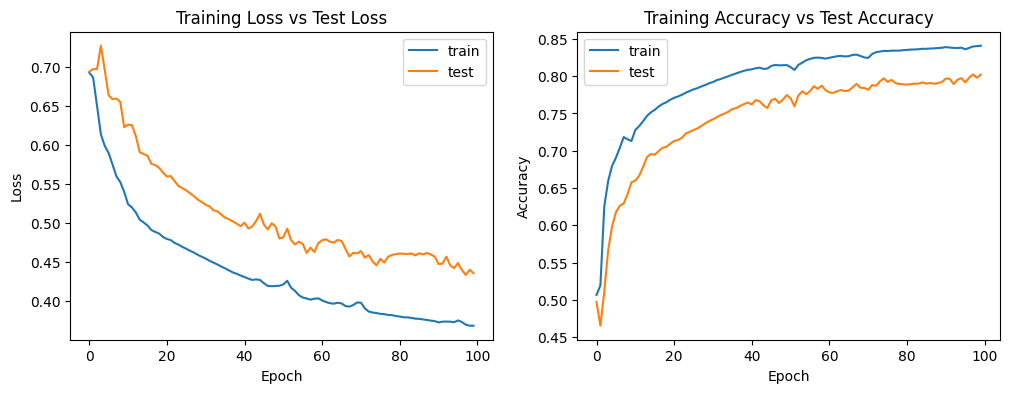

In [103]:

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(losses_train, label='train')
ax[0].plot(losses_test, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss vs Test Loss')
ax[0].legend()
ax[1].plot(acc_train, label='train')
ax[1].plot(acc_test, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy vs Test Accuracy')
ax[1].legend()
plt.show()


torch.Size([60, 128, 128])
torch.Size([60, 2, 128, 128])
tensor(0.6775, device='cuda:0')


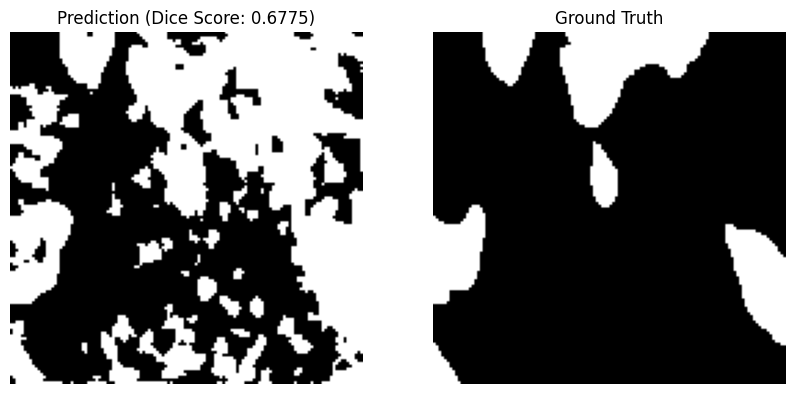

In [104]:
# plot a prediction
y_pred = predict(model, X_test)

idx = np.random.randint(0, len(y_pred))
dice_score = dice(y_pred[idx].int(), torch.argmax(Y_test[idx], dim=0).int(), num_classes=2)
print(dice_score)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(y_pred[idx].cpu().squeeze().numpy(), cmap='gray')
ax[0].set_title(f'Prediction (Dice Score: {dice_score:.4f})')
ax[0].axis('off')
ax[1].imshow(torch.argmax(Y_test[idx], dim=0).cpu().squeeze().numpy(), cmap='gray')
ax[1].set_title('Ground Truth')
ax[1].axis('off')
plt.show()




In [105]:
#cnn with weight decay - 1e-5
model_1 = CNN()
model_1 = model_1.to(device)
print(model_1)

n_epochs = 100
learning_rate = 0.001
batch_size = 10

loss_fn   = nn.CrossEntropyLoss(reduction='mean')
optimizer_1 = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=1e-5)
losses_train_1, losses_test_1, acc_train_1, acc_test_1 = model_train(model_1, X_train, Y_train, X_test, Y_test, n_epochs, loss_fn, optimizer_1, batch_size)


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (out): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
Finished epoch 0, train loss 0.6925, test loss 0.6932,            train acc 0.5425, test acc 0.4726
Finished epoch 1, train loss 0.6828, test loss 0.6909,            train acc 0.6109, test

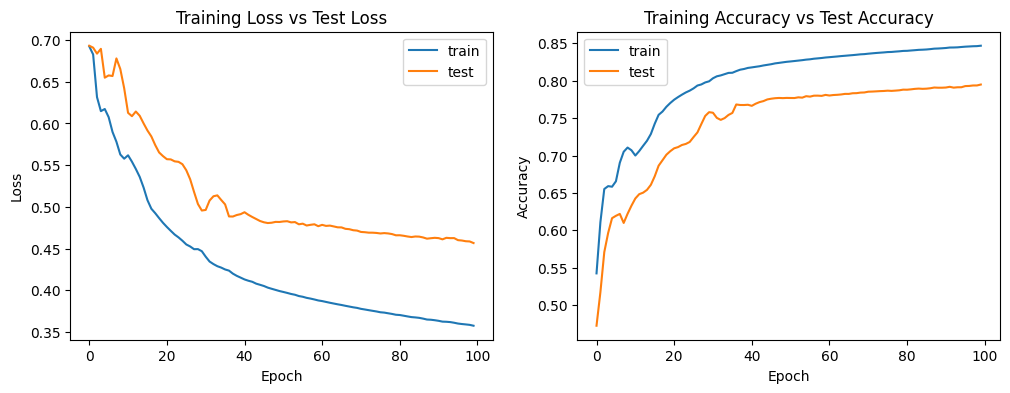

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(losses_train_1, label='train')
ax[0].plot(losses_test_1, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss vs Test Loss')
ax[0].legend()
ax[1].plot(acc_train_1, label='train')
ax[1].plot(acc_test_1, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy vs Test Accuracy')
ax[1].legend()
plt.show()

In [108]:
# cnn with dropout - 0.2
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.ConvTranspose2d(32, 64, 3, 2, 1, 1),  
        )
        self.dropout = nn.Dropout2d(0.2)
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 32, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(32, 64, 3, 2, 1, 1),              
        )
        self.dropout = nn.Dropout2d(0.2)
        self.conv3 = nn.Sequential(         
            nn.Conv2d(64, 32, 3, 1, 1),     
            nn.ReLU(),                      
        )
        # 1*1 convolution kernel
        self.out = nn.Conv2d(32, out_channels=2, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False)
    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(x)
        
        output = self.out(x)
        return output
model_2 = CNN()
model_2 = model_2.to(device)
print(model_2)

n_epochs = 100
learning_rate = 0.001
batch_size = 10

loss_fn   = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)
losses_train_2, losses_test_2, acc_train_2, acc_test_2 = model_train(model_2, X_train, Y_train, X_test, Y_test,
                                                            n_epochs=n_epochs,
                                                            loss_fn=loss_fn,
                                                            optimizer=optimizer,
                                                            batch_size=batch_size)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (dropout): Dropout2d(p=0.2, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (out): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
Finished epoch 0, train loss 0.6927, test loss 0.6934,            train acc 0.5259, test acc 0.4852
Finished epoch 1, train loss 0.6883, test l

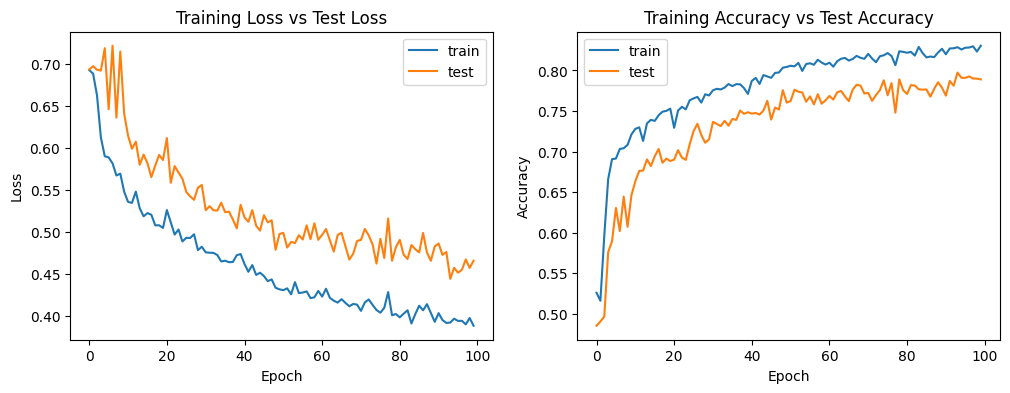

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(losses_train_2, label='train')
ax[0].plot(losses_test_2, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss vs Test Loss')
ax[0].legend()
ax[1].plot(acc_train_2, label='train')
ax[1].plot(acc_test_2, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy vs Test Accuracy')
ax[1].legend()
plt.show()

In [110]:
# cnn with batch normalization
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ), 
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),                             
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.ConvTranspose2d(32, 64, 3, 2, 1, 1),  
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 32, 3, 1, 1),  
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),   
            nn.ReLU(),                      
            nn.MaxPool2d(2),
            nn.ConvTranspose2d(32, 64, 3, 2, 1, 1),              
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),    
            nn.ReLU(),                      
        )
        # 1*1 convolution kernel
        self.out = nn.Conv2d(32, out_channels=2, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        output = self.out(x)
        return output
model_3 = CNN()
model_3 = model_3.to(device)
print(model_3)

n_epochs = 100
learning_rate = 0.001
batch_size = 10

loss_fn   = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)
losses_train_3, losses_test_3, acc_train_3, acc_test_3 = model_train(model_3, X_train, Y_train, X_test, Y_test,
                                                            n_epochs=n_epochs,
                                                            loss_fn=loss_fn,
                                                            optimizer=optimizer,
                                                            batch_size=batch_size)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU

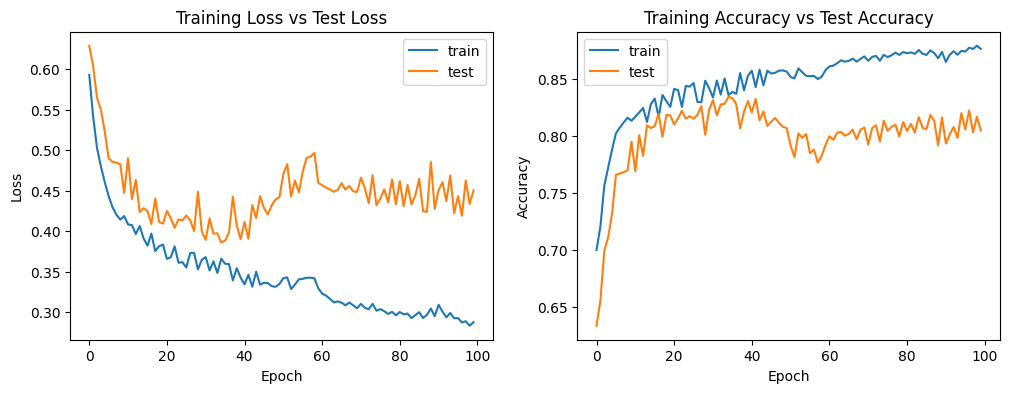

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(losses_train_3, label='train')
ax[0].plot(losses_test_3, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss vs Test Loss')
ax[0].legend()
ax[1].plot(acc_train_3, label='train')
ax[1].plot(acc_test_3, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy vs Test Accuracy')
ax[1].legend()
plt.show()

In [ ]:
# deeper cnn model - resenet50

def model_train(model, X_train, Y_train, X_test, Y_test, n_epochs,  loss_fn, optimizer, batch_size=5):
    losses_train, losses_test, acc_train, acc_test = [], [], [], []
    batch_start = torch.arange(0, len(X_train), batch_size)

    model.train()
    for epoch in range(n_epochs):
        for start in batch_start:
            X_batch = X_train[start:start+batch_size]
            Y_batch = Y_train[start:start+batch_size]
            y_pred = model(X_batch)['out']
            loss = loss_fn(y_pred, Y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            y_pred_train = model(X_train)['out']
            y_pred_test = model(X_test)['out']
        losses_train.append(loss_fn(y_pred_train, Y_train).item())
        losses_test.append(loss_fn(y_pred_test, Y_test).item())
        acc_train.append(acc_fn(y_pred_train, Y_train).item())
        acc_test.append(acc_fn(y_pred_test, Y_test).item())
        print(f'Finished epoch {epoch}, train loss {losses_train[-1]:.4f}, test loss {losses_test[-1]:.4f}, \
           train acc {acc_train[-1]:.4f}, test acc {acc_test[-1]:.4f}')
    return losses_train, losses_test, acc_train, acc_test

def predict(model, X):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)['out']
        y_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    return y_pred


model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
model = model.to(device)
print(model)

n_epochs = 100
learning_rate = 0.001
batch_size = 10

loss_fn   = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses_train, losses_test, acc_train, acc_test = model_train(model, X_train, Y_train, X_test, Y_test,
                                                            n_epochs=n_epochs,
                                                            loss_fn=loss_fn,
                                                            optimizer=optimizer,
                                                            batch_size=batch_size)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(losses_train, label='train')
ax[0].plot(losses_test, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss vs Test Loss')
ax[0].legend()
ax[1].plot(acc_train, label='train')
ax[1].plot(acc_test, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy vs Test Accuracy')
ax[1].legend()
plt.show()
